In [1]:
import pandas as pd
from langdetect import detect
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt

In [2]:
lem = WordNetLemmatizer() #create lemmatizer

In [3]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shirinharandi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
dictionary = pd.read_csv('../data/processedDict.csv')
dictionary

,word,cat_lev1,cat_lev2,cat_lev3,ndf
0,information,business,professional_conduct_host,advice,0.008904
1,recommendations,business,professional_conduct_host,advice,0.008375
2,tips,business,professional_conduct_host,advice,0.008399
3,advice,business,professional_conduct_host,advice,0.007568
4,suggestions,business,professional_conduct_host,advice,0.007580
...,...,...,...,...,...
347,talking,social,social_interaction,talking,0.001961
348,chatting,social,social_interaction,talking,0.001408
349,moments,social,social_interaction,talking,0.001155
350,chats,social,social_interaction,talking,0.000553


In [5]:
dictionary['word'] = dictionary['word'].apply(lambda x: lem.lemmatize(x, pos='n'))

In [6]:
filepath = '../data/en_reviews/belize_en.csv'
reviews = pd.read_csv(filepath)

# reviews = reviews['date']
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion
0,36666,145174,27/11/2010,278365,Rb,Monique and Maurice has put Caye Caulker at th...,en,0.039581
1,36666,167715,08/01/2011,258142,Angellini,"We had the best time, food and conversations w...",en,0.031722
2,36666,172375,19/01/2011,268097,Michael,"Great, great place to stay on Caye Caulker. Ve...",en,0.037152
3,36666,179895,08/02/2011,340713,Melinda,We stayed with Monique and Maurice for a coupl...,en,0.046602
4,36666,181056,12/02/2011,117024,Gail,Monique's guest house was great for us. It was...,en,0.055441
...,...,...,...,...,...,...,...,...
37705,39127463,557741654,01/11/2019,22844580,Cheryl,"Very clean, new place. There are 2 units, we ...",en,0.064935
37706,39183755,550911001,19/10/2019,41897670,Alice,Brandon’s room at Caye caulker is basic but co...,en,0.048851
37707,39183755,562960822,11/11/2019,23535832,Clara,Great spot! Loved having AC and a pool! \nBage...,en,0.025641
37708,39944342,565690422,17/11/2019,25461269,Moira,Great place!,en,0.090909


In [7]:
table = str.maketrans('', '', string.punctuation) #mapping to strip punctuation in review

In [8]:
#strip punct of each review -> lemmatise -> output is list of words so join into sentences
reviews['comments'] = reviews.comments.apply(lambda review: ' '.join(map(str, [lem.lemmatize(word.translate(table), pos='n') for word in review.lower().split()])))
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion
0,36666,145174,27/11/2010,278365,Rb,monique and maurice ha put caye caulker at the...,en,0.039581
1,36666,167715,08/01/2011,258142,Angellini,we had the best time food and conversation whi...,en,0.031722
2,36666,172375,19/01/2011,268097,Michael,great great place to stay on caye caulker very...,en,0.037152
3,36666,179895,08/02/2011,340713,Melinda,we stayed with monique and maurice for a coupl...,en,0.046602
4,36666,181056,12/02/2011,117024,Gail,moniques guest house wa great for u it wa exac...,en,0.055441
...,...,...,...,...,...,...,...,...
37705,39127463,557741654,01/11/2019,22844580,Cheryl,very clean new place there are 2 unit we were ...,en,0.064935
37706,39183755,550911001,19/10/2019,41897670,Alice,brandon’s room at caye caulker is basic but co...,en,0.048851
37707,39183755,562960822,11/11/2019,23535832,Clara,great spot loved having ac and a pool bagel in...,en,0.025641
37708,39944342,565690422,17/11/2019,25461269,Moira,great place,en,0.090909


In [9]:
def logTermFrequency(word, review):
    totalNumberOfWords = review.split()
    totalNumberOfWords = len(totalNumberOfWords)
    numberOfWord = review.count(word)
    if numberOfWord == 0:
        return 0;
    result = numberOfWord * 100/ totalNumberOfWords
    return result   

In [10]:
def adoptionForOneReview(category, review, dictionary):
    adoption = 0
    dictionaryWords = dictionary[(dictionary['cat_lev3'] == category)]
    dictionaryWords = dictionaryWords['word']
    for word in dictionaryWords:
        adoption = adoption + logTermFrequency(word, review)
    return adoption

In [11]:
reviews['social'] = reviews['comments'].apply(lambda x: adoptionForOneReview('social', x, dictionary))
reviews['meal'] = reviews['comments'].apply(lambda x: adoptionForOneReview('meal', x, dictionary))
reviews['people'] = reviews['comments'].apply(lambda x: adoptionForOneReview('people', x, dictionary))
reviews['personality_host'] = reviews['comments'].apply(lambda x: adoptionForOneReview('personality_host', x, dictionary))
reviews['sharing'] = reviews['comments'].apply(lambda x: adoptionForOneReview('sharing', x, dictionary))
reviews['talking'] = reviews['comments'].apply(lambda x: adoptionForOneReview('talking', x, dictionary))
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion,social,meal,people,personality_host,sharing,talking
0,36666,145174,27/11/2010,278365,Rb,monique and maurice ha put caye caulker at the...,en,0.039581,0,0.632911,13.924051,0.632911,0.0,0.632911
1,36666,167715,08/01/2011,258142,Angellini,we had the best time food and conversation whi...,en,0.031722,0,0.000000,10.909091,1.818182,0.0,3.636364
2,36666,172375,19/01/2011,268097,Michael,great great place to stay on caye caulker very...,en,0.037152,0,0.000000,14.062500,0.000000,0.0,0.000000
3,36666,179895,08/02/2011,340713,Melinda,we stayed with monique and maurice for a coupl...,en,0.046602,0,0.000000,16.666667,1.960784,0.0,0.000000
4,36666,181056,12/02/2011,117024,Gail,moniques guest house wa great for u it wa exac...,en,0.055441,0,1.063830,17.021277,4.255319,0.0,1.063830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37705,39127463,557741654,01/11/2019,22844580,Cheryl,very clean new place there are 2 unit we were ...,en,0.064935,0,0.000000,15.909091,2.272727,0.0,0.000000
37706,39183755,550911001,19/10/2019,41897670,Alice,brandon’s room at caye caulker is basic but co...,en,0.048851,0,2.985075,14.925373,4.477612,0.0,0.000000
37707,39183755,562960822,11/11/2019,23535832,Clara,great spot loved having ac and a pool bagel in...,en,0.025641,0,0.000000,4.545455,0.000000,0.0,0.000000
37708,39944342,565690422,17/11/2019,25461269,Moira,great place,en,0.090909,0,0.000000,0.000000,0.000000,0.0,0.000000


In [12]:
reviews['business'] = reviews['comments'].apply(lambda x: adoptionForOneReview('business', x, dictionary))
reviews['communication'] = reviews['comments'].apply(lambda x: adoptionForOneReview('communication', x, dictionary))
reviews['advice'] = reviews['comments'].apply(lambda x: adoptionForOneReview('advice', x, dictionary))
reviews['logistic'] = reviews['comments'].apply(lambda x: adoptionForOneReview('logistic', x, dictionary))
reviews['personality_host'] = reviews['comments'].apply(lambda x: adoptionForOneReview('personality_host', x, dictionary))
reviews['location'] = reviews['comments'].apply(lambda x: adoptionForOneReview('location', x, dictionary))
reviews['property_type'] = reviews['comments'].apply(lambda x: adoptionForOneReview('property_type', x, dictionary))
reviews['facilities'] = reviews['comments'].apply(lambda x: adoptionForOneReview('facilities', x, dictionary))
reviews['interiors'] = reviews['comments'].apply(lambda x: adoptionForOneReview('interiors', x, dictionary))

reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion,social,meal,...,sharing,talking,business,communication,advice,logistic,location,property_type,facilities,interiors
0,36666,145174,27/11/2010,278365,Rb,monique and maurice ha put caye caulker at the...,en,0.039581,0,0.632911,...,0.0,0.632911,0,0.0,0.632911,1.265823,4.430380,1.898734,0.000000,0.632911
1,36666,167715,08/01/2011,258142,Angellini,we had the best time food and conversation whi...,en,0.031722,0,0.000000,...,0.0,3.636364,0,0.0,0.000000,0.909091,4.545455,1.818182,0.000000,0.909091
2,36666,172375,19/01/2011,268097,Michael,great great place to stay on caye caulker very...,en,0.037152,0,0.000000,...,0.0,0.000000,0,0.0,0.000000,0.000000,6.250000,0.000000,1.562500,0.000000
3,36666,179895,08/02/2011,340713,Melinda,we stayed with monique and maurice for a coupl...,en,0.046602,0,0.000000,...,0.0,0.000000,0,0.0,1.960784,0.000000,3.921569,2.941176,0.000000,3.921569
4,36666,181056,12/02/2011,117024,Gail,moniques guest house wa great for u it wa exac...,en,0.055441,0,1.063830,...,0.0,1.063830,0,0.0,0.000000,0.000000,5.319149,1.063830,0.000000,6.382979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37705,39127463,557741654,01/11/2019,22844580,Cheryl,very clean new place there are 2 unit we were ...,en,0.064935,0,0.000000,...,0.0,0.000000,0,0.0,0.000000,0.000000,18.181818,2.272727,4.545455,2.272727
37706,39183755,550911001,19/10/2019,41897670,Alice,brandon’s room at caye caulker is basic but co...,en,0.048851,0,2.985075,...,0.0,0.000000,0,0.0,0.000000,0.000000,7.462687,0.000000,1.492537,4.477612
37707,39183755,562960822,11/11/2019,23535832,Clara,great spot loved having ac and a pool bagel in...,en,0.025641,0,0.000000,...,0.0,0.000000,0,0.0,0.000000,0.000000,4.545455,4.545455,0.000000,0.000000
37708,39944342,565690422,17/11/2019,25461269,Moira,great place,en,0.090909,0,0.000000,...,0.0,0.000000,0,0.0,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000


In [13]:
k_communication= reviews['communication'].loc[reviews['communication'] > 0]
k_advice = reviews['advice'].loc[reviews['advice'] > 0]
k_personality_host2 = reviews['personality_host'].loc[reviews['personality_host'] > 0]
k_logistic= reviews['logistic'].loc[reviews['logistic'] > 0]
k_location = reviews['location'].loc[reviews['location'] > 0]
k_property_type= reviews['property_type'].loc[reviews['property_type'] > 0]
k_facilities = reviews['facilities'].loc[reviews['facilities'] > 0]
k_interiors = reviews['interiors'].loc[reviews['interiors'] > 0]

k_communication = k_communication.min()
k_advice = k_advice.min()
k_personality_host2 = k_personality_host2.min()
k_logistic = k_logistic.min()
k_location = k_location.min()
k_property_type = k_property_type.min()
k_facilities = k_facilities.min()
k_interiors = k_interiors.min()
# print(k_meal)
# print(k_people)
# print(k_personality_host)
# print(k_sharing)
# print(k_talking)

In [14]:
k_meal = reviews['meal'].loc[reviews['meal'] > 0]
k_people = reviews['people'].loc[reviews['people'] > 0]
k_personality_host = reviews['personality_host'].loc[reviews['personality_host'] > 0]
k_sharing = reviews['sharing'].loc[reviews['sharing'] > 0]
k_talking = reviews['talking'].loc[reviews['talking'] > 0]
k_meal = k_meal.min()
k_people = k_people.min()
k_personality_host = k_personality_host.min()
k_sharing = k_sharing.min()
k_talking = k_talking.min()
print(k_meal)
print(k_people)
print(k_personality_host)
print(k_sharing)
print(k_talking)

0.12254901960784313
1.2195121951219512
0.13386880856760375
0.10020040080160321
0.13793103448275862


In [15]:
# k_business = reviews['business'].loc[reviews['business'] > 0]
# k_business = k_business.min()
# k_business

In [16]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [17]:
def adoptionForSetOfReviews(category, setOfReviews, dictionary, startDate, endDate, k):
    adoption = 1
    mask = (setOfReviews['date'] > startDate) & (setOfReviews['date'] < endDate)
    setOfReviews = setOfReviews.loc[mask]
    setOfReviews = setOfReviews[category]
    numOfReviews = len(setOfReviews)
    for review in setOfReviews:
        adoption *= (review + k)**(1 / numOfReviews)
    adoption = adoption - k
    return adoption

In [18]:
mask = (reviews['date'] > '2011-01-01') & (reviews['date'] < '2012-01-01')
setOfReviews = reviews.loc[mask]
setOfReviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion,social,meal,...,sharing,talking,business,communication,advice,logistic,location,property_type,facilities,interiors
1,36666,167715,2011-08-01,258142,Angellini,we had the best time food and conversation whi...,en,0.031722,0,0.000000,...,0.000000,3.636364,0,0.000000,0.000000,0.909091,4.545455,1.818182,0.000000,0.909091
2,36666,172375,2011-01-19,268097,Michael,great great place to stay on caye caulker very...,en,0.037152,0,0.000000,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,6.250000,0.000000,1.562500,0.000000
3,36666,179895,2011-08-02,340713,Melinda,we stayed with monique and maurice for a coupl...,en,0.046602,0,0.000000,...,0.000000,0.000000,0,0.000000,1.960784,0.000000,3.921569,2.941176,0.000000,3.921569
4,36666,181056,2011-12-02,117024,Gail,moniques guest house wa great for u it wa exac...,en,0.055441,0,1.063830,...,0.000000,1.063830,0,0.000000,0.000000,0.000000,5.319149,1.063830,0.000000,6.382979
5,36666,213948,2011-03-31,352643,John,very enjoyable accommodation in a splendidly r...,en,0.012048,0,0.000000,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,36666,284556,2011-05-28,460817,Lauren,our host monique and maurice were very friendl...,en,0.047486,0,0.000000,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,5.405405,0.000000,1.351351,0.000000
7,36666,299253,2011-06-06,373646,Jonathan,me and my new wife stayed at the caribbean gue...,en,0.041262,0,0.000000,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,7.500000,1.250000,0.000000,0.000000
8,36666,343979,2011-06-30,476448,Heather,monique is a fantastic host and the house is p...,en,0.041379,0,0.000000,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,5.769231,5.769231,0.000000,1.923077
9,36666,370677,2011-07-13,684361,Louise,word cannot describe how wonderful it wa to st...,en,0.036842,0,0.000000,...,0.970874,0.000000,0,0.000000,1.941748,0.000000,1.941748,0.000000,0.970874,0.000000
10,36666,401234,2011-07-27,824570,Mike,staying with monique and willy wa an unforgett...,en,0.058824,0,1.886792,...,1.886792,0.000000,0,0.000000,0.000000,0.000000,16.981132,1.886792,0.000000,0.000000


In [19]:
d2 = {'Year': [2010, 2010, 2010, 2010, 2010, 2010, 2010,2010, 2011,2011, 2011, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012,2012,
              2013, 2013,2013, 2013, 2013, 2013, 2013, 2013,2014,2014, 2014, 2014, 2014, 2014,2014, 2014, 2015, 2015,2015, 2015, 2015, 2015, 2015, 2015, 
              2016, 2016,2016, 2016, 2016, 2016,2016, 2016, 2017,2017, 2017, 2017, 2017, 2017, 2017, 2017,2018, 2018, 2018, 2018, 2018,2018,2018, 2018,
              2019, 2019, 2019,2019, 2019, 2019, 2019, 2019], 'Business sub-category' : ['location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                        'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                                                  'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                        'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                                                                        'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors',
                     
                                                                          'location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities','interiors'], 'value':0.0}
business_out = pd.DataFrame(data=d2)
business_out

,Year,Business sub-category,value
0,2010,location,0.0
1,2010,communication,0.0
2,2010,personality_host,0.0
3,2010,property_type,0.0
4,2010,logistic,0.0
...,...,...,...
75,2019,property_type,0.0
76,2019,logistic,0.0
77,2019,advice,0.0
78,2019,facilities,0.0


In [20]:
d = {'Year': [2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 
              2013, 2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2015, 
              2016, 2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 
              2019, 2019, 2019, 2019, 2019], 'Social sub-category' : ['meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking'], 'value':0.0}
social_out = pd.DataFrame(data=d)
social_out

,Year,Social sub-category,value
0,2010,meal,0.0
1,2010,people,0.0
2,2010,personality_host,0.0
3,2010,sharing,0.0
4,2010,talking,0.0
5,2011,meal,0.0
6,2011,people,0.0
7,2011,personality_host,0.0
8,2011,sharing,0.0
9,2011,talking,0.0


In [21]:
business_out.at[0, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2010-01-01', '2011-01-01', k_location)
business_out.at[8, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2011-01-01', '2012-01-01', k_location)
business_out.at[16, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2012-01-01', '2013-01-01', k_location)
business_out.at[24, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2013-01-01', '2014-01-01', k_location)
business_out.at[32, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2014-01-01', '2015-01-01', k_location)
business_out.at[40, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2015-01-01', '2016-01-01', k_location)
business_out.at[48, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2016-01-01', '2017-01-01', k_location)
business_out.at[56, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2017-01-01', '2018-01-01', k_location)
business_out.at[64, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2018-01-01', '2019-01-01', k_location)
business_out.at[72, 'value'] = adoptionForSetOfReviews('location', reviews, dictionary, '2019-01-01', '2020-01-01', k_location)

business_out.at[1, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2010-01-01', '2011-01-01', k_communication)
business_out.at[9, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2011-01-01', '2012-01-01', k_communication)
business_out.at[17, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2012-01-01', '2013-01-01', k_communication)
business_out.at[25, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2013-01-01', '2014-01-01', k_communication)
business_out.at[33, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2014-01-01', '2015-01-01', k_communication)
business_out.at[41, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2015-01-01', '2016-01-01', k_communication)
business_out.at[49, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2016-01-01', '2017-01-01', k_communication)
business_out.at[57, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2017-01-01', '2018-01-01', k_communication)
business_out.at[65, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2018-01-01', '2019-01-01', k_communication)
business_out.at[73, 'value'] = adoptionForSetOfReviews('communication', reviews, dictionary, '2019-01-01', '2020-01-01', k_communication)

business_out.at[2, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2010-01-01', '2011-01-01', k_personality_host2)
business_out.at[10, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2011-01-01', '2012-01-01', k_personality_host2)
business_out.at[18, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2012-01-01', '2013-01-01', k_personality_host2)
business_out.at[25, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2013-01-01', '2014-01-01', k_personality_host2)
business_out.at[34, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2014-01-01', '2015-01-01', k_personality_host2)
business_out.at[42, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2015-01-01', '2016-01-01', k_personality_host2)
business_out.at[50, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2016-01-01', '2017-01-01', k_personality_host2)
business_out.at[58, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2017-01-01', '2018-01-01', k_personality_host2)
business_out.at[66, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2018-01-01', '2019-01-01', k_personality_host2)
business_out.at[74, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2019-01-01', '2020-01-01', k_personality_host2)

business_out.at[3, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2010-01-01', '2011-01-01', k_property_type)
business_out.at[11, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2011-01-01', '2012-01-01', k_property_type)
business_out.at[19, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2012-01-01', '2013-01-01', k_property_type)
business_out.at[26, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2013-01-01', '2014-01-01', k_property_type)
business_out.at[35, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2014-01-01', '2015-01-01', k_property_type)
business_out.at[43, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2015-01-01', '2016-01-01', k_property_type)
business_out.at[51, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2016-01-01', '2017-01-01', k_property_type)
business_out.at[59, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2017-01-01', '2018-01-01', k_property_type)
business_out.at[67, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2018-01-01', '2019-01-01', k_property_type)
business_out.at[75, 'value'] = adoptionForSetOfReviews('property_type', reviews, dictionary, '2019-01-01', '2020-01-01', k_property_type)

business_out.at[4, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2010-01-01', '2011-01-01', k_logistic)
business_out.at[12, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2011-01-01', '2012-01-01', k_logistic)
business_out.at[20, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2012-01-01', '2013-01-01', k_logistic)
business_out.at[27, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2013-01-01', '2014-01-01', k_logistic)
business_out.at[36, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2014-01-01', '2015-01-01', k_logistic)
business_out.at[44, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2015-01-01', '2016-01-01', k_logistic)
business_out.at[52, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2016-01-01', '2017-01-01', k_logistic)
business_out.at[60, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2017-01-01', '2018-01-01', k_logistic)
business_out.at[68, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2018-01-01', '2019-01-01', k_logistic)
business_out.at[76, 'value'] = adoptionForSetOfReviews('logistic', reviews, dictionary, '2019-01-01', '2020-01-01', k_logistic)

business_out.at[5, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2010-01-01', '2011-01-01', k_advice)
business_out.at[13, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2011-01-01', '2012-01-01', k_advice)
business_out.at[21, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2012-01-01', '2013-01-01', k_advice)
business_out.at[29, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2013-01-01', '2014-01-01', k_advice)
business_out.at[37, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2014-01-01', '2015-01-01', k_advice)
business_out.at[45, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2015-01-01', '2016-01-01', k_advice)
business_out.at[53, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2016-01-01', '2017-01-01', k_advice)
business_out.at[61, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2017-01-01', '2018-01-01', k_advice)
business_out.at[69, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2018-01-01', '2019-01-01', k_advice)
business_out.at[77, 'value'] = adoptionForSetOfReviews('advice', reviews, dictionary, '2019-01-01', '2020-01-01', k_advice)

business_out.at[6, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2010-01-01', '2011-01-01', k_facilities)
business_out.at[14, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2011-01-01', '2012-01-01', k_facilities)
business_out.at[22, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2012-01-01', '2013-01-01', k_facilities)
business_out.at[30, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2013-01-01', '2014-01-01', k_facilities)
business_out.at[38, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2014-01-01', '2015-01-01', k_facilities)
business_out.at[46, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2015-01-01', '2016-01-01', k_facilities)
business_out.at[54, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2016-01-01', '2017-01-01', k_facilities)
business_out.at[62, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2017-01-01', '2018-01-01', k_facilities)
business_out.at[70, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2018-01-01', '2019-01-01', k_facilities)
business_out.at[78, 'value'] = adoptionForSetOfReviews('facilities', reviews, dictionary, '2019-01-01', '2020-01-01', k_facilities)

business_out.at[7, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2010-01-01', '2011-01-01', k_interiors)
business_out.at[15, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2011-01-01', '2012-01-01', k_interiors)
business_out.at[23, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2012-01-01', '2013-01-01', k_interiors)
business_out.at[31, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2013-01-01', '2014-01-01', k_interiors)
business_out.at[39, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2014-01-01', '2015-01-01', k_interiors)
business_out.at[47, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2015-01-01', '2016-01-01', k_interiors)
business_out.at[55, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2016-01-01', '2017-01-01', k_interiors)
business_out.at[63, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2017-01-01', '2018-01-01', k_interiors)
business_out.at[71, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2018-01-01', '2019-01-01', k_interiors)
business_out.at[79, 'value'] = adoptionForSetOfReviews('interiors', reviews, dictionary, '2019-01-01', '2020-01-01', k_interiors)

# # print(adoptionForSetOfReviews('location', reviews, dictionary, '2010-01-01', '2011-01-01', k_location))
business_out


,Year,Business sub-category,value
0,2010,location,1.019618e+01
1,2010,communication,-5.551115e-17
2,2010,personality_host,4.417922e-01
3,2010,property_type,3.460727e-01
4,2010,logistic,1.812100e-01
...,...,...,...
75,2019,property_type,4.158602e-01
76,2019,logistic,1.181510e-01
77,2019,advice,7.278607e-02
78,2019,facilities,1.462813e-01


In [22]:
social_out.at[0, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2010-01-01', '2011-01-01', k_meal)
social_out.at[5, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2011-01-01', '2012-01-01', k_meal)
social_out.at[10, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2012-01-01', '2013-01-01', k_meal)
social_out.at[15, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2013-01-01', '2014-01-01', k_meal)
social_out.at[20, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2014-01-01', '2015-01-01', k_meal)
social_out.at[25, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2015-01-01', '2016-01-01', k_meal)
social_out.at[30, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2016-01-01', '2017-01-01', k_meal)
social_out.at[35, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2017-01-01', '2018-01-01', k_meal)
social_out.at[40, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2018-01-01', '2019-01-01', k_meal)
social_out.at[45, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2019-01-01', '2020-01-01', k_meal)

social_out.at[1, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2010-01-01', '2011-01-01', k_people)
social_out.at[6, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2011-01-01', '2012-01-01', k_people)
social_out.at[11, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2012-01-01', '2013-01-01', k_people)
social_out.at[16, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2013-01-01', '2014-01-01', k_people)
social_out.at[21, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2014-01-01', '2015-01-01', k_people)
social_out.at[26, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2015-01-01', '2016-01-01', k_people)
social_out.at[31, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2016-01-01', '2017-01-01', k_people)
social_out.at[36, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2017-01-01', '2018-01-01', k_people)
social_out.at[41, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2018-01-01', '2019-01-01', k_people)
social_out.at[46, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2019-01-01', '2020-01-01', k_people)

social_out.at[2, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2010-01-01', '2011-01-01', k_personality_host)
social_out.at[7, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2011-01-01', '2012-01-01', k_personality_host)
social_out.at[12, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2012-01-01', '2013-01-01', k_personality_host)
social_out.at[17, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2013-01-01', '2014-01-01', k_personality_host)
social_out.at[22, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2014-01-01', '2015-01-01', k_personality_host)
social_out.at[27, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2015-01-01', '2016-01-01', k_personality_host)
social_out.at[32, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2016-01-01', '2017-01-01', k_personality_host)
social_out.at[37, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2017-01-01', '2018-01-01', k_personality_host)
social_out.at[42, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2018-01-01', '2019-01-01', k_personality_host)
social_out.at[47, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2019-01-01', '2020-01-01', k_personality_host)

social_out.at[3, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2010-01-01', '2011-01-01', k_sharing)
social_out.at[8, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2011-01-01', '2012-01-01', k_sharing)
social_out.at[13, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2012-01-01', '2013-01-01', k_sharing)
social_out.at[18, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2013-01-01', '2014-01-01', k_sharing)
social_out.at[23, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2014-01-01', '2015-01-01', k_sharing)
social_out.at[28, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2015-01-01', '2016-01-01', k_sharing)
social_out.at[33, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2016-01-01', '2017-01-01', k_sharing)
social_out.at[38, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2017-01-01', '2018-01-01', k_sharing)
social_out.at[43, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2018-01-01', '2019-01-01', k_sharing)
social_out.at[48, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2019-01-01', '2020-01-01', k_sharing)

social_out.at[4, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2010-01-01', '2011-01-01', k_talking)
social_out.at[9, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2011-01-01', '2012-01-01', k_talking)
social_out.at[14, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2012-01-01', '2013-01-01', k_talking)
social_out.at[19, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2013-01-01', '2014-01-01', k_talking)
social_out.at[24, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2014-01-01', '2015-01-01', k_talking)
social_out.at[29, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2015-01-01', '2016-01-01', k_talking)
social_out.at[34, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2016-01-01', '2017-01-01', k_talking)
social_out.at[39, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2017-01-01', '2018-01-01', k_talking)
social_out.at[44, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2018-01-01', '2019-01-01', k_talking)
social_out.at[49, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2019-01-01', '2020-01-01', k_talking)
# # print(adoptionForSetOfReviews('meal', reviews, dictionary, '2010-01-01', '2011-01-01', k_meal))
social_out


,Year,Social sub-category,value
0,2010,meal,0.323354
1,2010,people,16.825227
2,2010,personality_host,0.441792
3,2010,sharing,0.000000
4,2010,talking,0.171208
5,2011,meal,0.154948
6,2011,people,11.874402
7,2011,personality_host,1.068829
8,2011,sharing,0.045076
9,2011,talking,0.037398


In [23]:
# for2010b = adoptionForSetOfReviews('business', reviews, dictionary, '2010-01-01', '2011-01-01', k_business)
# for2011b = adoptionForSetOfReviews('business', reviews, dictionary, '2011-01-01', '2012-01-01', k_business)
# for2012b = adoptionForSetOfReviews('business', reviews, dictionary, '2012-01-01', '2013-01-01', k_business)
# for2013b = adoptionForSetOfReviews('business', reviews, dictionary, '2013-01-01', '2014-01-01', k_business)
# for2014b = adoptionForSetOfReviews('business', reviews, dictionary, '2014-01-01', '2015-01-01', k_business)
# for2015b = adoptionForSetOfReviews('business', reviews, dictionary, '2015-01-01', '2016-01-01', k_business)
# for2016b = adoptionForSetOfReviews('business', reviews, dictionary, '2016-01-01', '2017-01-01', k_business)
# for2017b = adoptionForSetOfReviews('business', reviews, dictionary, '2017-01-01', '2018-01-01', k_business)
# for2018b = adoptionForSetOfReviews('business', reviews, dictionary, '2018-01-01', '2019-01-01', k_business)
# for2019b = adoptionForSetOfReviews('business', reviews, dictionary, '2019-01-01', '2020-01-01', k_business)

# print("business")
# print("2010 = ",for2010b)
# print("2011 = ",for2011b)
# print("2012 = ",for2012b)
# print("2013 = ",for2013b)
# print("2014 = ",for2014b)
# print("2015 = ",for2015b)
# print("2016 = ",for2016b)
# print("2017 = ",for2017b)
# print("2018 = ",for2018b)
# print("2019 = ",for2019b)




In [24]:
business_out = business_out.loc[business_out['Year'] != 2010]
pivot_business = business_out.pivot(index='Year', columns='Business sub-category', values='value')
pivot_business

Business sub-category,advice,communication,facilities,interiors,location,logistic,personality_host,property_type
Year,,,,,,,,
2011,0.073155,0.034195,0.110763,0.542047,5.875235,0.119515,1.068829,0.566585
2012,0.063013,0.072420,0.154600,1.203994,5.942444,0.100840,1.270953,0.349804
2013,0.057281,0.959293,0.176616,1.174453,5.765924,0.000000,0.489673,0.158387
2014,0.083644,0.117990,0.175974,1.146831,5.814252,0.189263,1.136418,0.611382
2015,0.094991,0.093220,0.193864,1.380066,6.041320,0.177023,1.298964,0.693489
2016,0.086057,0.109180,0.172985,1.082443,6.359500,0.178220,1.206731,0.577583
2017,0.071369,0.099108,0.151892,0.930619,7.629459,0.129820,0.818486,0.474876
2018,0.077871,0.104236,0.145172,0.856265,7.763724,0.123286,0.739989,0.439097
2019,0.072786,0.100329,0.146281,0.891797,7.897178,0.118151,0.668241,0.415860


In [25]:
social_out = social_out.loc[social_out['Year'] != 2010]
pivot_social = social_out.pivot(index='Year', columns='Social sub-category', values='value')
pivot_social

Social sub-category,meal,people,personality_host,sharing,talking
Year,,,,,
2011,0.154948,11.874402,1.068829,0.045076,0.037398
2012,0.084367,12.340754,1.270953,0.066052,0.013259
2013,0.090485,10.629348,0.959293,0.040474,0.020344
2014,0.114538,11.919764,1.136418,0.078979,0.033469
2015,0.098210,11.707716,1.298964,0.068782,0.020118
2016,0.085816,11.787107,1.206731,0.061939,0.021402
2017,0.065102,10.066926,0.818486,0.038788,0.013164
2018,0.056720,9.491581,0.739989,0.034838,0.011194
2019,0.055336,9.145543,0.668241,0.032757,0.010357


Text(0.5, 1.0, 'Belize')

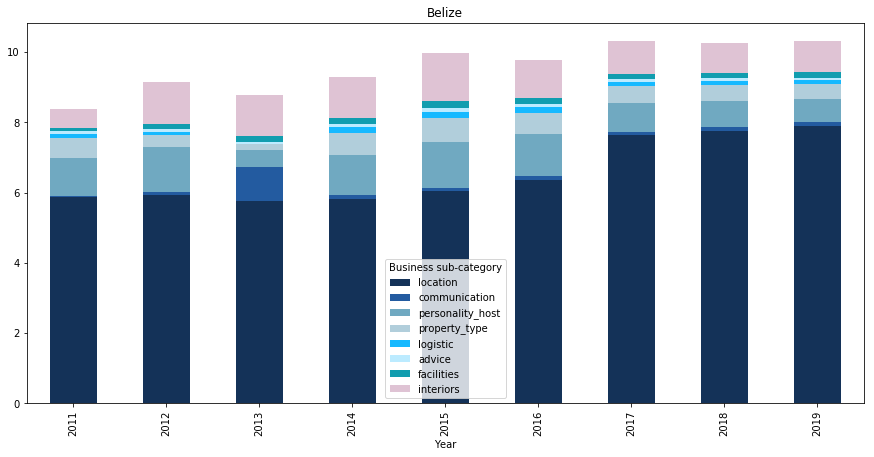

In [26]:
pivot_business.loc[:,['location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities', 'interiors']].plot.bar(stacked=True, figsize=(15,7), color=['#143258','#235BA0','#70A9C1','#B1CEDB','#16B9FF','#BCEBFF','#119DAF', '#DFC3D4'])
plt.title("Belize")

Text(0.5, 1.0, 'Belize')

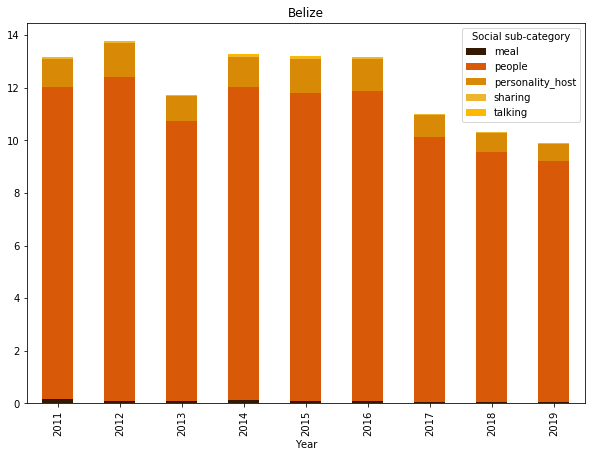

In [27]:
pivot_social.loc[:,['meal','people', 'personality_host', 'sharing', 'talking']].plot.bar(stacked=True, figsize=(10,7), color=['#351800','#D85907','#D88A07','#EEB531','#FFB800'])
plt.title("Belize")

In [28]:
for2010 = adoptionForSetOfReviews('social', reviews, dictionary, '2010-01-01', '2011-01-01', k_social)
for2011 = adoptionForSetOfReviews('social', reviews, dictionary, '2011-01-01', '2012-01-01', k_social)
for2012 = adoptionForSetOfReviews('social', reviews, dictionary, '2012-01-01', '2013-01-01', k_social)
for2013 = adoptionForSetOfReviews('social', reviews, dictionary, '2013-01-01', '2014-01-01', k_social)
for2014 = adoptionForSetOfReviews('social', reviews, dictionary, '2014-01-01', '2015-01-01', k_social)
for2015 = adoptionForSetOfReviews('social', reviews, dictionary, '2015-01-01', '2016-01-01', k_social)
for2016 = adoptionForSetOfReviews('social', reviews, dictionary, '2016-01-01', '2017-01-01', k_social)
for2017 = adoptionForSetOfReviews('social', reviews, dictionary, '2017-01-01', '2018-01-01', k_social)
for2018 = adoptionForSetOfReviews('social', reviews, dictionary, '2018-01-01', '2019-01-01', k_social)
for2019 = adoptionForSetOfReviews('social', reviews, dictionary, '2019-01-01', '2020-01-01', k_social)

print("social")
print("2010 = ",for2010)
print("2011 = ",for2011)
print("2012 = ",for2012)
print("2013 = ",for2013)
print("2014 = ",for2014)
print("2015 = ",for2015)
print("2016 = ",for2016)
print("2017 = ",for2017)
print("2018 = ",for2018)
print("2019 = ",for2019)

NameError: name 'k_social' is not defined

In [ ]:
for2010b = adoptionForSetOfReviews('business', reviews, dictionary, '2010-01-01', '2011-01-01', k_business)
for2011b= adoptionForSetOfReviews('business', reviews, dictionary, '2011-01-01', '2012-01-01', k_business)
for2012b = adoptionForSetOfReviews('business', reviews, dictionary, '2012-01-01', '2013-01-01', k_business)
for2013b = adoptionForSetOfReviews('business', reviews, dictionary, '2013-01-01', '2014-01-01', k_business)
for2014b = adoptionForSetOfReviews('business', reviews, dictionary, '2014-01-01', '2015-01-01', k_business)
for2015b = adoptionForSetOfReviews('business', reviews, dictionary, '2015-01-01', '2016-01-01', k_business)
for2016b = adoptionForSetOfReviews('business', reviews, dictionary, '2016-01-01', '2017-01-01', k_business)
for2017b = adoptionForSetOfReviews('business', reviews, dictionary, '2017-01-01', '2018-01-01', k_business)
for2018b = adoptionForSetOfReviews('business', reviews, dictionary, '2018-01-01', '2019-01-01', k_business)
for2019b = adoptionForSetOfReviews('business', reviews, dictionary, '2019-01-01', '2020-01-01', k_business)

print("business")
print("2010 = ",for2010b)
print("2011 = ",for2011b)
print("2012 = ",for2012b)
print("2013 = ",for2013b)
print("2014 = ",for2014b)
print("2015 = ",for2015b)
print("2016 = ",for2016b)
print("2017 = ",for2017b)
print("2018 = ",for2018b)
print("2019 = ",for2019b)

In [ ]:
x_axis = [for2010b, for2011b, for2012b, for2013b, for2014b, for2015b, for2016b, for2017b, for2018b, for2019b]
df = pd.DataFrame(x_axis, index = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], columns = ['business adoption'])
df
df.plot.bar()

In [ ]:
x_axis = [for2010, for2011, for2012, for2013, for2014, for2015, for2016, for2017, for2018, for2019]
df = pd.DataFrame(x_axis, index = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], columns = ['social adoption'])
df
df.plot.bar()